In [1]:
import argparse
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io
import scipy.misc
import numpy as np
import pandas as pd
import PIL
import tensorflow as tf
from keras import backend as K
from keras.layers import Input, Lambda, Conv2D
from keras.models import load_model, Model
from yolo_utils import read_classes, read_anchors, generate_colors, preprocess_image, draw_boxes, scale_boxes
from yad2k.models.keras_yolo import yolo_head, yolo_boxes_to_corners, preprocess_true_boxes, yolo_loss, yolo_body

%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = .6):
    """Filters YOLO boxes by thresholding on object and class confidence.
    
    Arguments:
    box_confidence -- tensor of shape (19, 19, 5, 1)
    boxes -- tensor of shape (19, 19, 5, 4)
    box_class_probs -- tensor of shape (19, 19, 5, 80)
    threshold -- real value
    
    Returns:
    scores -- tensor of shape (None,), containing the class probability score for selected boxes
    boxes -- tensor of shape (None, 4), containing (b_x, b_y, b_h, b_w) coordinates of selected boxes
    classes -- tensor of shape (None,), containing the index of the class detected by the selected boxes

    """
    
    #Compute box scores
    box_scores = box_confidence * box_class_probs
    
    #Find the box_classes thanks to the max box_scores, keep track of the corresponding score
    box_classes = K.argmax(box_scores, axis = -1)
    box_class_scores = K.max(box_scores, axis = -1)
    
    #Create a filtering mask based on box_class_scores using threshold
    filtering_mask = box_class_scores >= threshold
    
    #Apply the mask to scores, boxes and classes
    scores = tf.boolean_mask(box_class_scores, filtering_mask)
    boxes = tf.boolean_mask(boxes, filtering_mask)
    classes = tf.boolean_mask(box_classes, filtering_mask)
    
    return scores, boxes, classes

In [3]:
def iou(box1, box2):
    """Implement the intersection over union (IoU) between box1 and box2
    
    Arguments:
    box1 -- first box, list object with coordinates (x1, y1, x2, y2)
    box2 -- second box, list object with coordinates (x1, y1, x2, y2)
    """

    #Calculate the (y1, x1, y2, x2) coordinates of the intersection of box1 and box2. Calculate its Area.
    xi1 = max(box1[0], box2[0])
    yi1 = max(box1[1], box2[1])
    xi2 = min(box1[2], box2[2])
    yi2 = min(box1[3], box2[3])
    inter_area = (xi2 - xi1) * (yi2 - yi1)   

    #Calculate the Union area by using Formula: Union(A,B) = A + B - Inter(A,B)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - inter_area
    
    #Compute the IoU
    iou = inter_area / union_area

    return iou

In [4]:
def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):
    """
    Applies Non-max suppression (NMS) to set of boxes
    
    Arguments:
    scores -- tensor of shape (None,), output of yolo_filter_boxes()
    boxes -- tensor of shape (None, 4), output of yolo_filter_boxes() that have been scaled to the image size
    classes -- tensor of shape (None,), output of yolo_filter_boxes()
    max_boxes -- integer, maximum number of predicted boxes you'd like
    iou_threshold -- real value
    
    Returns:
    scores -- tensor of shape (, None), predicted score for each box
    boxes -- tensor of shape (4, None), predicted box coordinates
    classes -- tensor of shape (, None), predicted class for each box
    
    """
    
    max_boxes_tensor = K.variable(max_boxes, dtype='int32') # tensor to be used in tf.image.non_max_suppression()
    K.get_session().run(tf.variables_initializer([max_boxes_tensor])) # initialize variable max_boxes_tensor
    
    nms_indices = tf.image.non_max_suppression(boxes, scores, max_boxes_tensor, iou_threshold)
    scores = K.gather(scores, nms_indices)
    boxes = K.gather(boxes, nms_indices)
    classes = K.gather(classes, nms_indices)
    
    return scores, boxes, classes

In [5]:
def yolo_eval(yolo_outputs, image_shape = (720., 1280.), max_boxes=10, score_threshold=.6, iou_threshold=.5):
    """
    Converts the output of YOLO encoding (a lot of boxes) to your predicted boxes along with their scores, box coordinates and classes.
    
    Arguments:
    yolo_outputs -- output of the encoding model (for image_shape of (608, 608, 3)), contains 4 tensors
    image_shape -- tensor of shape (2,) containing the input shape, in this notebook we use (608., 608.) (has to be float32 dtype)
    max_boxes -- integer, maximum number of predicted boxes you'd like
    score_threshold -- real value, if [ highest class probability score < threshold], then get rid of the corresponding box
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (None, ), predicted score for each box
    boxes -- tensor of shape (None, 4), predicted box coordinates
    classes -- tensor of shape (None,), predicted class for each box
    
    """
    
    #Retrieving outputs of the YOLO model
    box_confidence, box_xy, box_wh, box_class_probs = yolo_outputs

    #Convertint boxes to be ready for filtering functions 
    boxes = yolo_boxes_to_corners(box_xy, box_wh)

    #Performing score-filtering
    scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, score_threshold)
    
    #Scaling boxes back to original image shape.
    boxes = scale_boxes(boxes, image_shape)

    #Performing non-max suppression
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes, max_boxes, iou_threshold)
    
    return scores, boxes, classes

In [6]:
###Testing###

In [7]:
sess = K.get_session()

In [8]:
class_names = read_classes("model_data/coco_classes.txt")
anchors = read_anchors("model_data/yolo_anchors.txt")
image_shape = (720., 1280.)

In [9]:
yolo_model = load_model("model_data/yolo.h5")

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [10]:
yolo_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 608, 608, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 608, 608, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 608, 608, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 608, 608, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_poolin

In [11]:
yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names))

In [12]:
scores, boxes, classes = yolo_eval(yolo_outputs, image_shape)

In [24]:
def predict(sess, image, image_data, frame_num): #image_file):
    """
    Runs the graph stored in sess to predict boxes for image_file. Prints and plots the preditions.
    
    Arguments:
    sess -- your tensorflow/Keras session containing the YOLO graph
    image_file -- name of an image stored in the "images" folder.
    
    Returns:
    out_scores -- tensor of shape (None, ), scores of the predicted boxes
    out_boxes -- tensor of shape (None, 4), coordinates of the predicted boxes
    out_classes -- tensor of shape (None, ), class index of the predicted boxes
    
    """
    #image, image_data = preprocess_image("images/" + image_file, model_image_size = (608, 608)) #608, 608
#     from PIL import Image
#     imshow(Image.fromarray(image_data[0], 'RGB'))
#     plt.figure()
#     print(image_data.shape)
    img_output_file = str(frame_num) + ".jpg"
    out_scores, out_boxes, out_classes = sess.run([scores, boxes, classes], feed_dict={yolo_model.input: image_data, K.learning_phase(): 0})
    print('Found {} boxes for {}'.format(len(out_boxes), img_output_file))
    colors = generate_colors(class_names)
    draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors)
    image.save(os.path.join("out", img_output_file), quality=90)
    output_image = scipy.misc.imread(os.path.join("out", img_output_file))
    imshow(output_image)
    
    return out_scores, out_boxes, out_classes

In [25]:
#out_scores, out_boxes, out_classes = predict(sess, "test2.png")

Running main
Video Frame  0
Found 2 boxes for 0.jpg
person 0.66 (115, 507) (608, 608)
person 0.67 (1132, 284) (608, 417)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:26: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


[[ 284.0972  1132.225    416.95175 1174.8667 ]
 [ 507.27798  114.52488  733.70306 1272.7471 ]]
Video Frame  1
Video Frame  2
Video Frame  3
Video Frame  4
Video Frame  5
Video Frame  6
Video Frame  7
Video Frame  8
Video Frame  9
Video Frame  10
Video Frame  11
Video Frame  12
Video Frame  13
Video Frame  14
Video Frame  15
Video Frame  16
Video Frame  17
Video Frame  18
Video Frame  19
Video Frame  20
Found 0 boxes for 20.jpg
[]
Video Frame  21
Video Frame  22
Video Frame  23
Video Frame  24
Video Frame  25
Video Frame  26
Video Frame  27
Video Frame  28
Video Frame  29
Video Frame  30
Video Frame  31
Video Frame  32
Video Frame  33
Video Frame  34
Video Frame  35
Video Frame  36
Video Frame  37
Video Frame  38
Video Frame  39
Video Frame  40
Found 0 boxes for 40.jpg
[]
Video Frame  41
Video Frame  42
Video Frame  43
Video Frame  44
Video Frame  45
Video Frame  46
Video Frame  47
Video Frame  48
Video Frame  49
Video Frame  50
Video Frame  51
Video Frame  52
Video Frame  53
Video Fram

Found 7 boxes for 240.jpg
person 0.62 (322, 194) (379, 350)
person 0.65 (649, 135) (608, 304)
person 0.72 (348, 372) (432, 601)
person 0.72 (0, 257) (95, 465)
person 0.73 (1056, 225) (608, 477)
person 0.75 (583, 288) (608, 531)
person 0.76 (244, 199) (332, 430)
[[ 198.88022    243.71991    430.35223    331.6742   ]
 [ 287.9696     582.87604    531.32794    672.9612   ]
 [ 225.42412   1055.594      477.3133    1135.0667   ]
 [ 257.23218     -1.7308187  465.11237     95.15034  ]
 [ 371.72723    348.48938    601.2831     432.06476  ]
 [ 134.65192    649.1852     303.60144    795.3229   ]
 [ 193.9386     322.39777    349.5354     378.88245  ]]
Video Frame  241
Video Frame  242
Video Frame  243
Video Frame  244
Video Frame  245
Video Frame  246
Video Frame  247
Video Frame  248
Video Frame  249
Video Frame  250
Video Frame  251
Video Frame  252
Video Frame  253
Video Frame  254
Video Frame  255
Video Frame  256
Video Frame  257
Video Frame  258
Video Frame  259
Video Frame  260
Found 5 boxe

Found 3 boxes for 460.jpg
person 0.60 (612, 242) (608, 374)
person 0.61 (935, 348) (608, 506)
person 0.77 (429, 383) (558, 570)
[[ 382.82333  428.99997  569.9388   558.2619 ]
 [ 348.1309   935.387    505.91492 1003.8398 ]
 [ 241.83348  612.45514  374.01788  680.25604]]
Video Frame  461
Video Frame  462
Video Frame  463
Video Frame  464
Video Frame  465
Video Frame  466
Video Frame  467
Video Frame  468
Video Frame  469
Video Frame  470
Video Frame  471
Video Frame  472
Video Frame  473
Video Frame  474
Video Frame  475
Video Frame  476
Video Frame  477
Video Frame  478
Video Frame  479
Video Frame  480
Found 3 boxes for 480.jpg
person 0.63 (307, 357) (399, 578)
person 0.64 (2, 317) (82, 495)
person 0.66 (176, 436) (293, 608)
[[435.5476   175.96127  638.063    293.3998  ]
 [316.99814    1.804986 494.91968   82.25918 ]
 [357.45438  306.88187  578.16156  399.44037 ]]
Video Frame  481
Video Frame  482
Video Frame  483
Video Frame  484


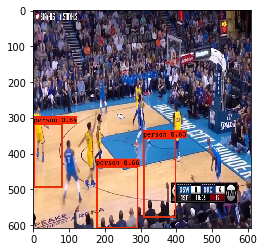

In [43]:
import os
import cv2
import time
import argparse
import multiprocessing
import numpy as np
import tensorflow as tf
from keras import backend as K
from keras.layers import Input, Lambda, Conv2D
from keras.models import load_model, Model

from PIL import Image, ImageDraw, ImageFont

CWD_PATH = os.getcwd()

#NUMWORKERS = 2
FILENAME = '../videos/bball2.mp4'

IMAGE_WIDTH = 608
IMAGE_HEIGHT = 608
FRAME_GAP = 20
BUFFER_SIZE = 4

global OBJECTS_LIST
OBJECTS_LIST = []

#TODO Fill out actual main items
if __name__ == '__main__':
    print("Running main")

    cap = cv2.VideoCapture(FILENAME)
    frame_num = 0
    image_buffer = []

    while(cap.isOpened()):
        print("Video Frame ", frame_num)
        ret, frame = cap.read()
        if frame is None:
            break
        if frame_num % FRAME_GAP == 0:
            #add a frame to the current buffer
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame_rgb = cv2.resize(frame_rgb, (IMAGE_WIDTH, IMAGE_HEIGHT))
            image = Image.fromarray(frame_rgb)     #image = Image.open("images/test2.png")#
#             pix = np.array(image.getdata())
#             image = cv2.resize(pix, (IMAGE_WIDTH, IMAGE_HEIGHT))
            model_image_size = (608, 608)
#             1, 1080, 1920, 3
            resized_image = image
            #resized_image = image.resize(tuple(reversed(model_image_size)), Image.BICUBIC)
            image_data = np.array(resized_image, dtype='float32')
            image_data /= 255.
            image_data = np.expand_dims(image_data, 0)
            out_scores, out_boxes, out_classes = predict(sess, image, image_data, frame_num)
            print(out_boxes)
            #image_buffer.append(frame_rgb)
#         if len(image_buffer) == BUFFER_SIZE:
#             print("pushing buffer")
#             #THIS IS WHERE WE DO STUFF WITH A FULL BUFFER
#             #val = run_detection_on_buffer(image_buffer)
#             #print(val)
#             #EMPTY BUFFER
#             image_buffer = []
        frame_num += 1

    cap.release()